In [1]:
import numpy as np
import pandas as pd
import math
import itertools

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL

from sklearn.metrics import mean_squared_error

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

Using TensorFlow backend.


In [2]:
import warnings
warnings.filterwarnings("ignore")

# Load and process the data

In [3]:
df = pd.read_csv('CarbonEmissions.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.head()

,Date,Carbon
0,1959-01-01,315.42
1,1959-02-01,316.32
2,1959-03-01,316.49
3,1959-04-01,317.56
4,1959-05-01,318.13


In [4]:
y = pd.Series(data=df['Carbon'].values, index=df['Date'])
y.head()

Date
1959-01-01    315.42
1959-02-01    316.32
1959-03-01    316.49
1959-04-01    317.56
1959-05-01    318.13
dtype: float64

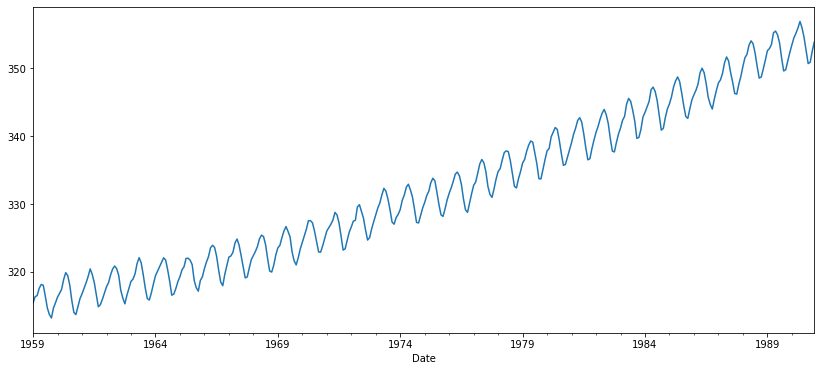

In [5]:
y.plot(figsize=(14, 6))
plt.show()

In [6]:
data = y.values.reshape(y.size,1)

# LSTM Forecast Model

### LSTM Data Preparation

In [7]:
'MixMaxScaler'
scaler = MinMaxScaler(feature_range=(0, 1))
data   = scaler.fit_transform(data)

In [8]:
train_size  = int(len(data) * 0.8)
test_size   = len(data) - train_size
train, test = data[0:train_size,:], data[train_size:len(data),:]
print('data train size :',train.shape[0])
print('data test size  :',test.shape[0])

data train size : 307
data test size  : 77


In [9]:
'function to reshape data according to the number of lags'

def reshape_data (data, look_back,time_steps):
    
    sub_seqs = int(look_back/time_steps)
    dataX, dataY = [], []
    for i in range(len(data)-look_back-1):
        a = data[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(data[i + look_back, 0])
    
    dataX = np.array(dataX)
    dataY = np.array(dataY)
    
    dataX = np.reshape(dataX,(dataX.shape[0],sub_seqs,time_steps,np.size(data,1)))
    return dataX, dataY

In [10]:
look_back = 2
time_steps = 1

trainX, trainY = reshape_data(train, look_back,time_steps)
testX, testY = reshape_data(test, look_back,time_steps)
print('train shape :',trainX.shape)
print('test shape  :',testX.shape)

train shape : (304, 2, 1, 1)
test shape  : (74, 2, 1, 1)


## Define and Fit  the Model

In [11]:
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, time_steps, 1)))

model.add(TimeDistributed(MaxPooling1D(pool_size=1)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

history = model.fit(trainX, trainY, epochs=100, validation_data=(testX, testY), verbose=0)

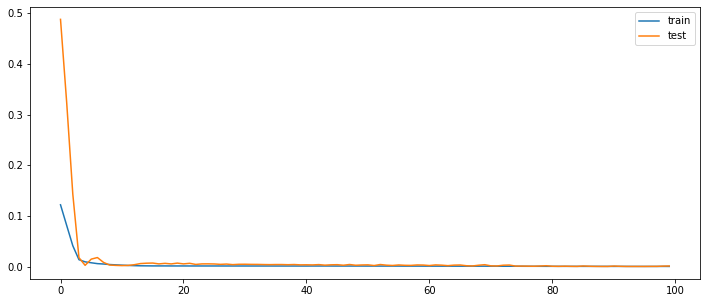

In [12]:
'plot history'
plt.figure(figsize=(12,5))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Test the performances

In [13]:
'make predictions'
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [14]:
'invert predictions'
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [15]:
'calculate root mean squared error' 
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.95 RMSE
Test Score: 1.59 RMSE


In [16]:
'shift train predictions for plotting'
trainPredictPlot = np.empty_like(data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

'shift test predictions for plotting'
testPredictPlot = np.empty_like(data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(data)-1, :] = testPredict

In [17]:
'Make as pandas series to plot'
data_series = pd.Series(scaler.inverse_transform(data).ravel(), index=df['Date'])
trainPredict_series = pd.Series(trainPredictPlot.ravel(), index=df['Date'])
testPredict_series  = pd.Series(testPredictPlot.ravel(), index=df['Date'])

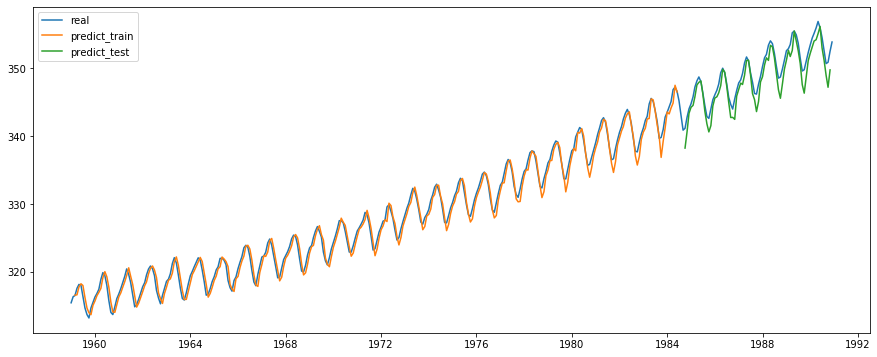

In [18]:
'plot baseline and predictions'
plt.figure(figsize=(15,6))
plt.plot(data_series,label = 'real')
plt.plot(trainPredict_series,label = 'predict_train')
plt.plot(testPredict_series,label = 'predict_test')
plt.legend()
plt.show()

In [19]:
'Predict all the data'
dataX, dataY = reshape_data(data, look_back,time_steps)
dataPredict = model.predict(dataX)

dataPredict = scaler.inverse_transform(dataPredict)
dataY = scaler.inverse_transform([dataY])

dataPredictPlot = np.empty_like(data)
dataPredictPlot[:, :] = np.nan
dataPredictPlot[look_back:len(dataPredict)+look_back, :] = dataPredict

dataPredict_series = pd.Series(dataPredictPlot.ravel(), index=df['Date'])

## STL Decomposing 

In [20]:
predicted = dataPredict_series.dropna()

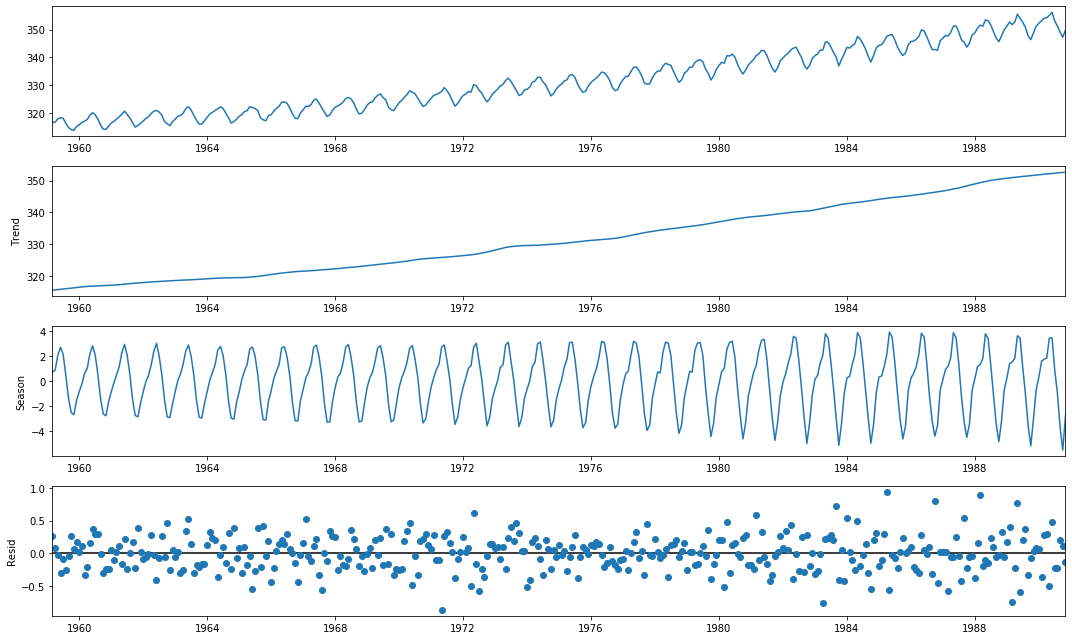

In [21]:
rcParams['figure.figsize'] = 15, 9
stl = STL(predicted).fit()
fig = stl.plot()
plt.show()

## Seasonal plot 

In [22]:
df_predicted = predicted.to_frame().reset_index()
df_predicted = df_predicted.rename(columns= {0: 'Carbon'})

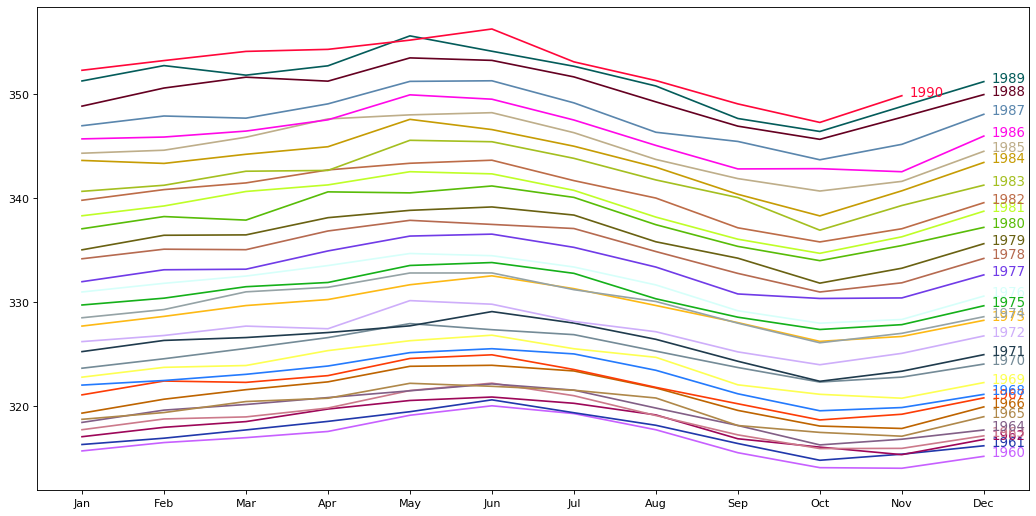

In [23]:
# Prepare data

df_predicted['year'] = [d.year for d in df_predicted.Date]
df_predicted['month'] = [d.strftime('%b') for d in df_predicted.Date]
years = df_predicted['year'].unique()

# Prep Colors
np.random.seed(100)
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)

# Draw Plot
plt.figure(figsize=(16,8), dpi= 80)
for i, y in enumerate(years):
    if i > 0:        
        plt.plot('month', 'Carbon', data=df_predicted.loc[df_predicted.year==y, :], color=mycolors[i], label=y)
        plt.text(df_predicted.loc[df_predicted.year==y, :].shape[0]-.9,
                 df_predicted.loc[df_predicted.year==y, 'Carbon'][-1:].values[0],
                 y, fontsize=12, color=mycolors[i])

## Boxplot of Month-wise (Seasonal) and Year-wise (trend) Distribution

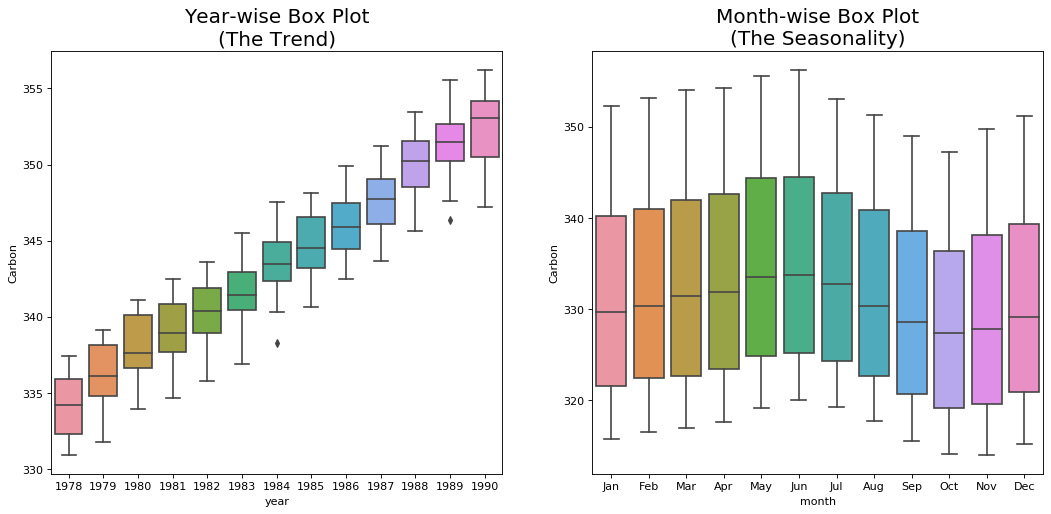

In [24]:
# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(16,7), dpi= 80)
sns.boxplot(x='year', y='Carbon', data=df_predicted[-150:], ax=axes[0])
sns.boxplot(x='month', y='Carbon', data=df_predicted.loc[~df_predicted.year.isin([1959, 1991]), :])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

# SARIMA Model

## 1. Grid search the p, d, q parameters

In [25]:
'Define the p, d and q parameters to take any value between 0 and 3'
p = d = q = range(0, 3)

'Generate all different combinations of p, q and q triplets'
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [28]:
warnings.filterwarnings("ignore") # specify to ignore warning messages
best_result = [0, 0, 10000000]
for param in pdq:
    for param_seasonal in seasonal_pdq:
        
        mod = sm.tsa.statespace.SARIMAX(predicted,
                                        order=param,
                                        seasonal_order=param_seasonal,
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)

        results = mod.fit()
            
        print('ARIMA{} x {} - AIC: {}'.format(param, param_seasonal, results.aic))

        if results.aic < best_result[2]:
            best_result = [param, param_seasonal, results.aic]
print('\nBest Result:', best_result)

ARIMA(0, 0, 0) x (0, 0, 0, 12) - AIC: 5492.092987584424
ARIMA(0, 0, 0) x (0, 0, 1, 12) - AIC: 4863.848275155905
ARIMA(0, 0, 0) x (0, 0, 2, 12) - AIC: 4296.619711360248
ARIMA(0, 0, 0) x (0, 1, 0, 12) - AIC: 1276.821899510548
ARIMA(0, 0, 0) x (0, 1, 1, 12) - AIC: 1118.6010143143214
ARIMA(0, 0, 0) x (0, 1, 2, 12) - AIC: 1019.2112765376144
ARIMA(0, 0, 0) x (0, 2, 0, 12) - AIC: 1034.6014228318388
ARIMA(0, 0, 0) x (0, 2, 1, 12) - AIC: 755.4435337185326
ARIMA(0, 0, 0) x (0, 2, 2, 12) - AIC: 691.8365700512618
ARIMA(0, 0, 0) x (1, 0, 0, 12) - AIC: 769.2892463916445
ARIMA(0, 0, 0) x (1, 0, 1, 12) - AIC: 761.8634197268007
ARIMA(0, 0, 0) x (1, 0, 2, 12) - AIC: 740.9148734818014
ARIMA(0, 0, 0) x (1, 1, 0, 12) - AIC: 986.5139566972794
ARIMA(0, 0, 0) x (1, 1, 1, 12) - AIC: 756.2575164284953
ARIMA(0, 0, 0) x (1, 1, 2, 12) - AIC: 667.5877435531214
ARIMA(0, 0, 0) x (1, 2, 0, 12) - AIC: 872.9921560074803
ARIMA(0, 0, 0) x (1, 2, 1, 12) - AIC: 734.941695330836
ARIMA(0, 0, 0) x (1, 2, 2, 12) - AIC: 693.8351

ARIMA(0, 1, 2) x (1, 1, 0, 12) - AIC: 543.0916995602237
ARIMA(0, 1, 2) x (1, 1, 1, 12) - AIC: 503.688725844522
ARIMA(0, 1, 2) x (1, 1, 2, 12) - AIC: 491.4739657717359
ARIMA(0, 1, 2) x (1, 2, 0, 12) - AIC: 785.7767535094762
ARIMA(0, 1, 2) x (1, 2, 1, 12) - AIC: 565.0846986350953
ARIMA(0, 1, 2) x (1, 2, 2, 12) - AIC: 487.6768954175015
ARIMA(0, 1, 2) x (2, 0, 0, 12) - AIC: 545.0568160226527
ARIMA(0, 1, 2) x (2, 0, 1, 12) - AIC: 503.58032005286486
ARIMA(0, 1, 2) x (2, 0, 2, 12) - AIC: 498.58230226293813
ARIMA(0, 1, 2) x (2, 1, 0, 12) - AIC: 507.3544894272527
ARIMA(0, 1, 2) x (2, 1, 1, 12) - AIC: 498.7767977523519
ARIMA(0, 1, 2) x (2, 1, 2, 12) - AIC: 493.7156419107441
ARIMA(0, 1, 2) x (2, 2, 0, 12) - AIC: 673.1803541101947
ARIMA(0, 1, 2) x (2, 2, 1, 12) - AIC: 529.6204500647393
ARIMA(0, 1, 2) x (2, 2, 2, 12) - AIC: 513.844002688525
ARIMA(0, 2, 0) x (0, 0, 0, 12) - AIC: 1314.473913698491
ARIMA(0, 2, 0) x (0, 0, 1, 12) - AIC: 1197.528462185378
ARIMA(0, 2, 0) x (0, 0, 2, 12) - AIC: 1121.38156

ARIMA(1, 0, 1) x (2, 1, 2, 12) - AIC: 497.6232001522857
ARIMA(1, 0, 1) x (2, 2, 0, 12) - AIC: 663.9443446030493
ARIMA(1, 0, 1) x (2, 2, 1, 12) - AIC: 529.5209253009162
ARIMA(1, 0, 1) x (2, 2, 2, 12) - AIC: 520.0129321144079
ARIMA(1, 0, 2) x (0, 0, 0, 12) - AIC: 1207.1807697862318
ARIMA(1, 0, 2) x (0, 0, 1, 12) - AIC: 1053.3174029273514
ARIMA(1, 0, 2) x (0, 0, 2, 12) - AIC: 1009.8948154706751
ARIMA(1, 0, 2) x (0, 1, 0, 12) - AIC: 638.7103847757269
ARIMA(1, 0, 2) x (0, 1, 1, 12) - AIC: 501.44490433317327
ARIMA(1, 0, 2) x (0, 1, 2, 12) - AIC: 494.2937268304559
ARIMA(1, 0, 2) x (0, 2, 0, 12) - AIC: 964.8506369049462
ARIMA(1, 0, 2) x (0, 2, 1, 12) - AIC: 630.5561739229406
ARIMA(1, 0, 2) x (0, 2, 2, 12) - AIC: 488.23931032532835
ARIMA(1, 0, 2) x (1, 0, 0, 12) - AIC: 630.838933986128
ARIMA(1, 0, 2) x (1, 0, 1, 12) - AIC: 513.5796956011823
ARIMA(1, 0, 2) x (1, 0, 2, 12) - AIC: 500.8776917961013
ARIMA(1, 0, 2) x (1, 1, 0, 12) - AIC: 544.4309175966914
ARIMA(1, 0, 2) x (1, 1, 1, 12) - AIC: 506.43

ARIMA(1, 2, 1) x (0, 2, 2, 12) - AIC: 544.4631454961124
ARIMA(1, 2, 1) x (1, 0, 0, 12) - AIC: 688.6734912985601
ARIMA(1, 2, 1) x (1, 0, 1, 12) - AIC: 560.3994057621788
ARIMA(1, 2, 1) x (1, 0, 2, 12) - AIC: 549.5233995031086
ARIMA(1, 2, 1) x (1, 1, 0, 12) - AIC: 591.1134503473841
ARIMA(1, 2, 1) x (1, 1, 1, 12) - AIC: 547.3512795397655
ARIMA(1, 2, 1) x (1, 1, 2, 12) - AIC: 536.1365487138434
ARIMA(1, 2, 1) x (1, 2, 0, 12) - AIC: 826.1003853768357
ARIMA(1, 2, 1) x (1, 2, 1, 12) - AIC: 622.1174621519608
ARIMA(1, 2, 1) x (1, 2, 2, 12) - AIC: 546.7373240458194
ARIMA(1, 2, 1) x (2, 0, 0, 12) - AIC: 593.2717654546328
ARIMA(1, 2, 1) x (2, 0, 1, 12) - AIC: 550.2255534176313
ARIMA(1, 2, 1) x (2, 0, 2, 12) - AIC: 548.4104033760057
ARIMA(1, 2, 1) x (2, 1, 0, 12) - AIC: 559.0618374859937
ARIMA(1, 2, 1) x (2, 1, 1, 12) - AIC: 540.1316148859967
ARIMA(1, 2, 1) x (2, 1, 2, 12) - AIC: 538.2522690695669
ARIMA(1, 2, 1) x (2, 2, 0, 12) - AIC: 718.6117539075099
ARIMA(1, 2, 1) x (2, 2, 1, 12) - AIC: 589.396912

ARIMA(2, 1, 0) x (2, 0, 2, 12) - AIC: 516.149746031587
ARIMA(2, 1, 0) x (2, 1, 0, 12) - AIC: 522.9398292710837
ARIMA(2, 1, 0) x (2, 1, 1, 12) - AIC: 512.7012898882372
ARIMA(2, 1, 0) x (2, 1, 2, 12) - AIC: 512.6909844796892
ARIMA(2, 1, 0) x (2, 2, 0, 12) - AIC: 689.7093406854601
ARIMA(2, 1, 0) x (2, 2, 1, 12) - AIC: 545.4990985123944
ARIMA(2, 1, 0) x (2, 2, 2, 12) - AIC: 536.337797319183
ARIMA(2, 1, 1) x (0, 0, 0, 12) - AIC: 1113.3226179228839
ARIMA(2, 1, 1) x (0, 0, 1, 12) - AIC: 1003.9975537533294
ARIMA(2, 1, 1) x (0, 0, 2, 12) - AIC: 911.1769401703921
ARIMA(2, 1, 1) x (0, 1, 0, 12) - AIC: 640.396408579312
ARIMA(2, 1, 1) x (0, 1, 1, 12) - AIC: 500.2623799703561
ARIMA(2, 1, 1) x (0, 1, 2, 12) - AIC: 493.59460863465347
ARIMA(2, 1, 1) x (0, 2, 0, 12) - AIC: 974.9197802882579
ARIMA(2, 1, 1) x (0, 2, 1, 12) - AIC: 644.0173395362285
ARIMA(2, 1, 1) x (0, 2, 2, 12) - AIC: 488.94915330211234
ARIMA(2, 1, 1) x (1, 0, 0, 12) - AIC: 641.6754416182996
ARIMA(2, 1, 1) x (1, 0, 1, 12) - AIC: 512.49009

## Auto Sarima

In [43]:
import pmdarima as pm

smodel = pm.auto_arima(df_predicted.Carbon, start_p=1, start_q=1,
                         test='adf',
                         max_p=4, max_q=4, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=2, trace=True,
                         max_P = 4, max_Q = 4, 
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
Fit ARIMA: (1, 0, 1)x(0, 2, 1, 12) (constant=True); AIC=659.394, BIC=678.782, Time=4.785 seconds
Fit ARIMA: (0, 0, 0)x(0, 2, 0, 12) (constant=True); AIC=1038.580, BIC=1046.335, Time=0.066 seconds
Fit ARIMA: (1, 0, 0)x(1, 2, 0, 12) (constant=True); AIC=840.738, BIC=856.249, Time=0.963 seconds
Fit ARIMA: (0, 0, 1)x(0, 2, 1, 12) (constant=True); AIC=715.866, BIC=731.377, Time=3.087 seconds
Near non-invertible roots for order (0, 0, 1)(0, 2, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (0, 0, 0)x(0, 2, 0, 12) (constant=False); AIC=1036.600, BIC=1040.477, Time=0.048 seconds
Fit ARIMA: (1, 0, 1)x(0, 2, 0, 12) (constant=True); AIC=976.476, BIC=991.986, Time=0.665 seconds
Fit ARIMA: (1, 0, 1)x(1, 2, 1, 12) (constant=True); AIC=591.304, BIC=614.571, Time=5.633 seconds
Near non-invertible roots for order (1, 0, 1)(1, 2, 1, 12); setting score to inf (at least one inverse root too cl

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  381
Model:             SARIMAX(1, 0, 1)x(0, 2, [1, 2], 12)   Log Likelihood                -262.007
Date:                                 Mon, 18 May 2020   AIC                            536.014
Time:                                         15:05:34   BIC                            559.280
Sample:                                              0   HQIC                           545.268
                                                 - 381                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0020      0.001      2.115      0.034       0.000       0.004
ar.L1          0.9400      0.027     35.352      0.000       0.888       0.992
ma.L1         -0.6810      0.051    -13.399      0.000      -0.781      -0.581
ma.S.L12      -1.8029      0.111    -16.286      0.000      -2.020      -1.586
ma.S.L24       0.8123      0.080     10.161      0.000       0.656       0.969
sigma2         0.2023      0.031      6.461      0.000       0.141       0.264
===================================================================================
Ljung-Box (Q):                       31.07   Jarque-Bera (JB):                 1.19
Prob(Q):                              0.84   Prob(JB):                         0.55
Heteroskedasticity (H):               2.45   Skew:                             0.00
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Train the model

In [50]:
del mod 
mod = sm.tsa.statespace.SARIMAX(predicted,
                                order=(1, 0, 1),
                                seasonal_order=(0, 2, [1,2], 12),
                                enforce_stationarity=True,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  381
Model:             SARIMAX(1, 0, 1)x(0, 2, [1, 2], 12)   Log Likelihood                -265.625
Date:                                 Mon, 18 May 2020   AIC                            541.250
Time:                                         15:14:44   BIC                            560.638
Sample:                                     03-01-1959   HQIC                           548.961
                                          - 11-01-1990                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9997      0.008    123.480      0.000       0.984       1

## Plot model diagnostics

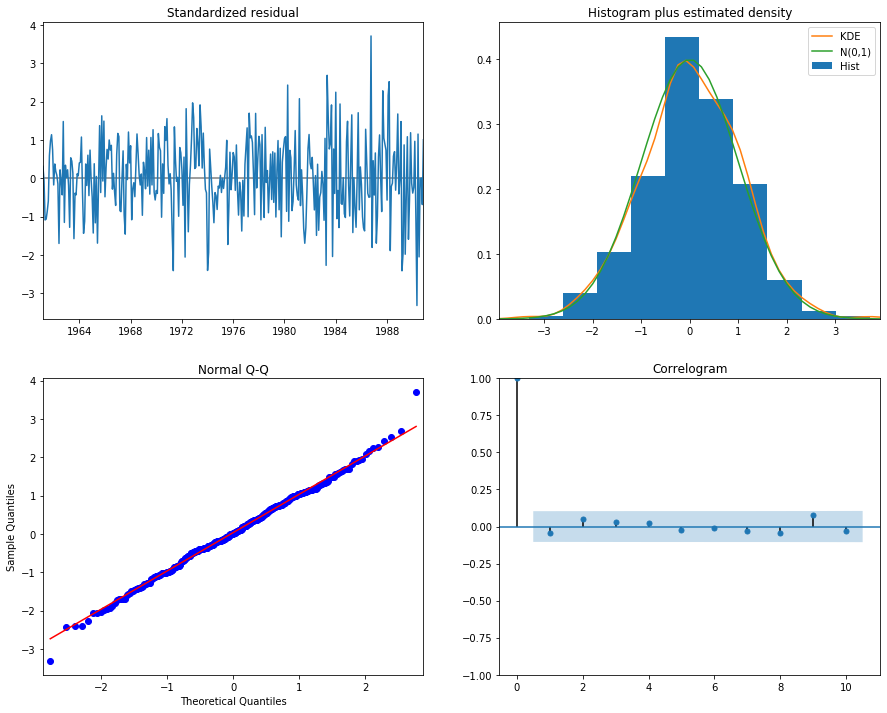

In [32]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [34]:
'make predictions'
pred = results.get_prediction(start=pd.to_datetime('1959-03-01'), dynamic=False,full_results=True)
pred_ci = pred.conf_int()

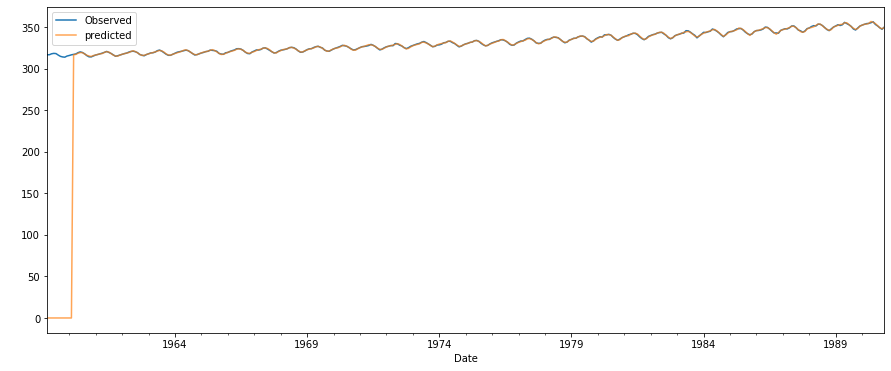

In [35]:
ax = predicted.plot(label='Observed', figsize=(15, 6))
pred.predicted_mean.plot(ax=ax, label='predicted', alpha=.7)

ax.set_xlabel('Date')
ax.set_ylabel(' ')
plt.legend()

plt.show()

In [36]:
trainScore = math.sqrt(mean_squared_error(predicted, pred.predicted_mean))
print('Score: %.2f RMSE' % (trainScore))

Score: 56.09 RMSE


## Explain the params (p,d,q) S(P,D,Q)

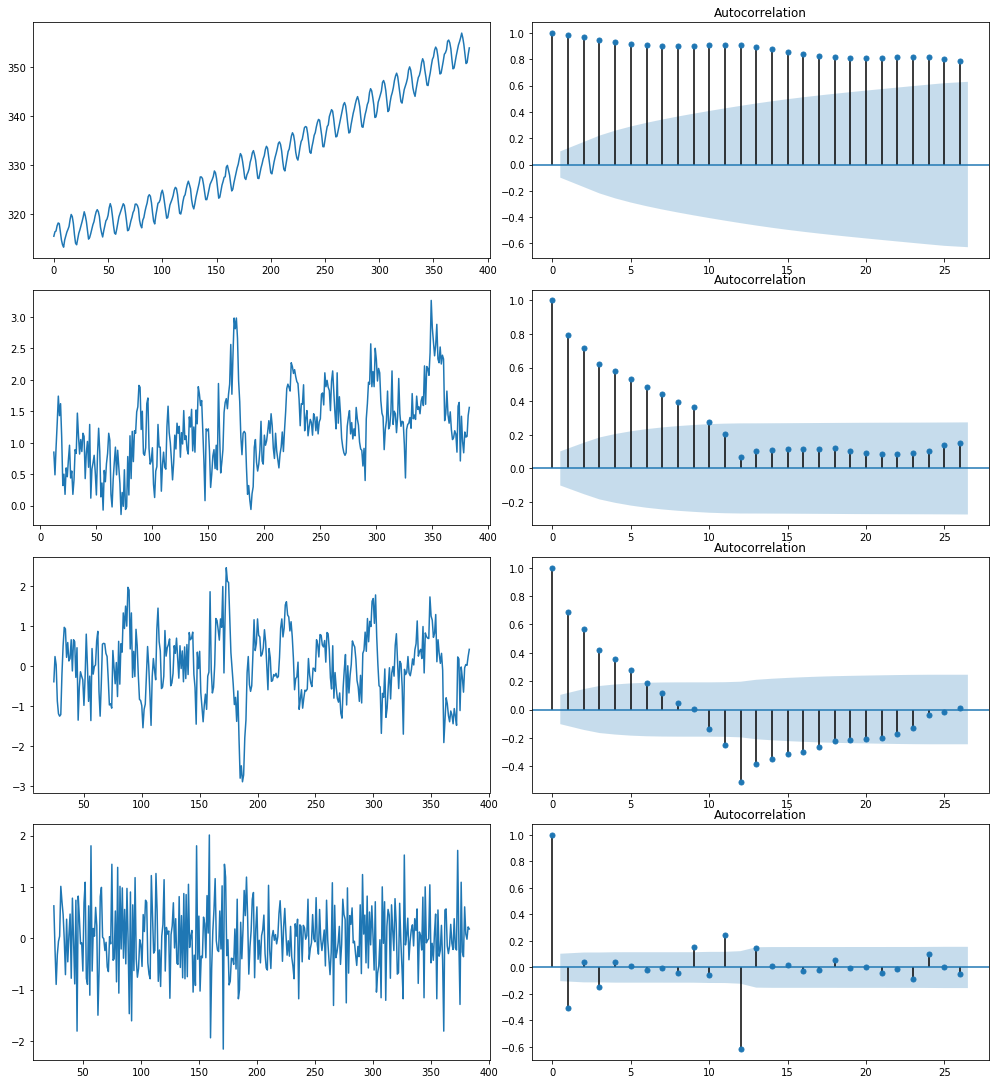

In [44]:
'parameters (D & d) : the orders of differencing'

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Original Series
fig, axes = plt.subplots(4, 2,figsize=(14,15))
fig.tight_layout()
axes[0, 0].plot(df.Carbon); axes[0, 0].set_title('')
plot_acf(df.Carbon, ax=axes[0, 1])

axes[1, 0].plot(df.Carbon.diff(12)); axes[1, 0].set_title('')
plot_acf(df.Carbon.diff(12).dropna(), ax=axes[1, 1])

axes[2, 0].plot(df.Carbon.diff(12).diff(12)); axes[2, 0].set_title('')
plot_acf(df.Carbon.diff(12).diff(12).dropna(), ax=axes[2, 1])

axes[3, 0].plot(df.Carbon.diff(12).diff(12).diff()); axes[3, 0].set_title('')
plot_acf(df.Carbon.diff(12).diff(12).diff().dropna(), ax=axes[3, 1])

plt.show()

In [45]:
'Adfuller test' 
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df.Carbon.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('------------------------')

result = adfuller(df.Carbon.diff(12).dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('------------------------')

result = adfuller(df.Carbon.diff(12).diff(12).dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('------------------------')

result = adfuller(df.Carbon.diff(12).diff(12).diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('------------------------')

ADF Statistic: 2.773939
p-value: 1.000000
------------------------
ADF Statistic: -3.454126
p-value: 0.009246
------------------------
ADF Statistic: -4.962289
p-value: 0.000026
------------------------
ADF Statistic: -8.422428
p-value: 0.000000
------------------------


In [ ]:
'Plot the lags'
from pandas.plotting import lag_plot

fig, axes = plt.subplots(1, 5, figsize=(12,3), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:5]):
    if i < 4 :
        lag_plot(df.Passengers, lag=i+1, ax=ax, c='firebrick')
        ax.set_title('Lag ' + str(i+1))
    else :
        lag_plot(df.Passengers, lag=12, ax=ax, c='firebrick')
        ax.set_title('Lag 12')
fig.suptitle('Original Series', y=1.05)

'-------------------------------------------------------------------------------------------'
    
fig, axes = plt.subplots(1, 5, figsize=(12,3), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:5]):
    if i < 4 : 
        lag_plot(df.Passengers.diff(12).dropna(), lag=i+1, ax=ax, c='firebrick')
        ax.set_title('Lag ' + str(i+1))
    else :
        lag_plot(df.Passengers.diff(12).dropna(), lag=12, ax=ax, c='firebrick')
        ax.set_title('Lag 12')
fig.suptitle('d = 0 & D = 1', y=1.05)

'-------------------------------------------------------------------------------------------'

fig, axes = plt.subplots(1, 5, figsize=(12,3), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:5]):
    if i < 4 : 
        lag_plot(df.Passengers.diff().dropna(), lag=i+1, ax=ax, c='firebrick')
        ax.set_title('Lag ' + str(i+1))
    else :
        lag_plot(df.Passengers.diff().dropna(), lag=12, ax=ax, c='firebrick')
        ax.set_title('Lag 12')
fig.suptitle('d = 1 & D = 0', y=1.05)

'-------------------------------------------------------------------------------------------'

fig, axes = plt.subplots(1, 5, figsize=(12,3), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:5]):
    if i < 4 : 
        lag_plot(df.Passengers.diff(12).diff().dropna(), lag=i+1, ax=ax, c='firebrick')
        ax.set_title('Lag ' + str(i+1))
    else :
        lag_plot(df.Passengers.diff(12).diff().dropna(), lag=12, ax=ax, c='firebrick')
        ax.set_title('Lag 12')
fig.suptitle('d = 1 & D = 1', y=1.05)

plt.show()

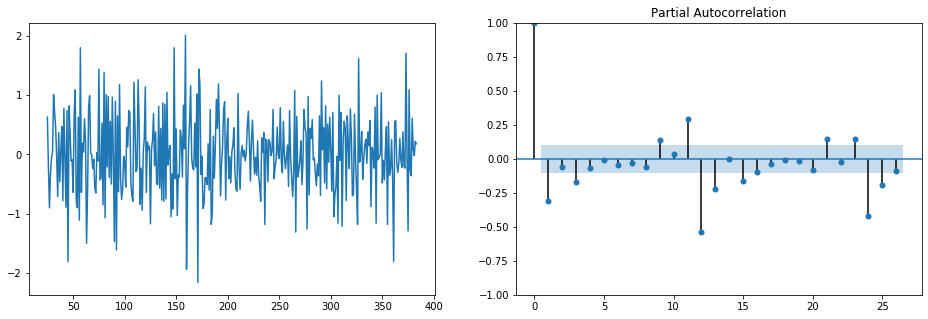

In [46]:
'parameters (P & p)  : orders of AR & SAR terms respectively '

fig, axes = plt.subplots(1, 2, figsize=(16,5), sharex=False)
axes[0].plot(df.Carbon.diff(12).diff(12).diff()); axes[0].set_title('')
axes[1].set(ylim=(-1,1))
plot_pacf(df.Carbon.diff(12).diff(12).diff().dropna(), ax=axes[1])

plt.show()

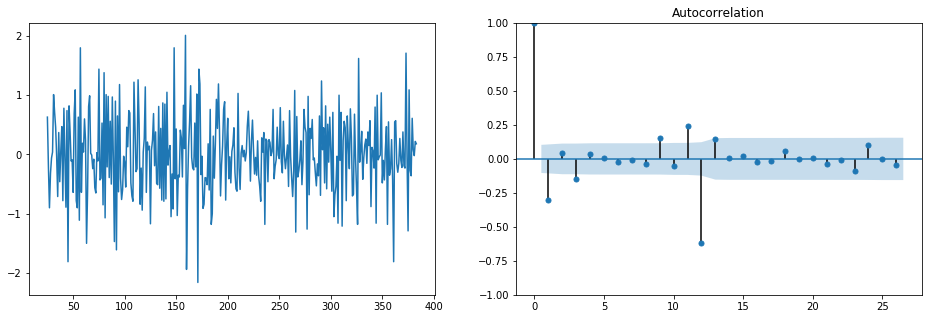

In [51]:
'parameters (Q & q)  : orders of MA & SMA terms respectively '


fig, axes = plt.subplots(1, 2, figsize=(16,5), sharex=False)
axes[0].plot(df.Carbon.diff(12).diff(12).diff()); axes[0].set_title('')
axes[1].set(ylim=(-1,1))
plot_acf(df.Carbon.diff(12).diff(12).diff().dropna(), ax=axes[1])

plt.show()